# Fridge Detection Model

This notebook implements a YOLOv8-based object detection model for identifying food items in fridge images.

## Setup Instructions

Before running this notebook, you need to:

1. **Install dependencies**: Run `pip install -r requirements.txt`
2. **Set up Roboflow API key**: 
   - Get your API key from [Roboflow](https://roboflow.com/)
   - Set it as an environment variable:
     ```bash
     export ROBOFLOW_API_KEY="your_api_key_here"
     ```
   - Or in Python/Jupyter:
     ```python
     import os
     os.environ['ROBOFLOW_API_KEY'] = 'your_api_key_here'
     ```

## Dataset Information

The model recognizes 30 food categories:
apple, banana, beef, blueberries, bread, butter, carrot, cheese, chicken, chicken_breast, chocolate, corn, eggs, flour, goat_cheese, green_beans, ground_beef, ham, heavy_cream, lime, milk, mushrooms, onion, potato, shrimp, spinach, strawberries, sugar, sweet_potato, tomato

In [ ]:
!pip install roboflow
!pip install ultralytics
!pip install albumentations opencv-python

import os
from roboflow import Roboflow

# Get API key from environment variable
api_key = os.getenv('ROBOFLOW_API_KEY')
if not api_key:
    raise ValueError("Please set the ROBOFLOW_API_KEY environment variable")

rf = Roboflow(api_key=api_key)
project = rf.workspace("karel-cornelis-q2qqg").project("aicook-lcv4d")
version = project.version(1)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.8 MB/s eta 0:00:00
   


Extracting Dataset Version Zip to aicook-1 in yolov8:: 100%|██████████| 1044/1044 [00:00<00:00, 3011.80it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


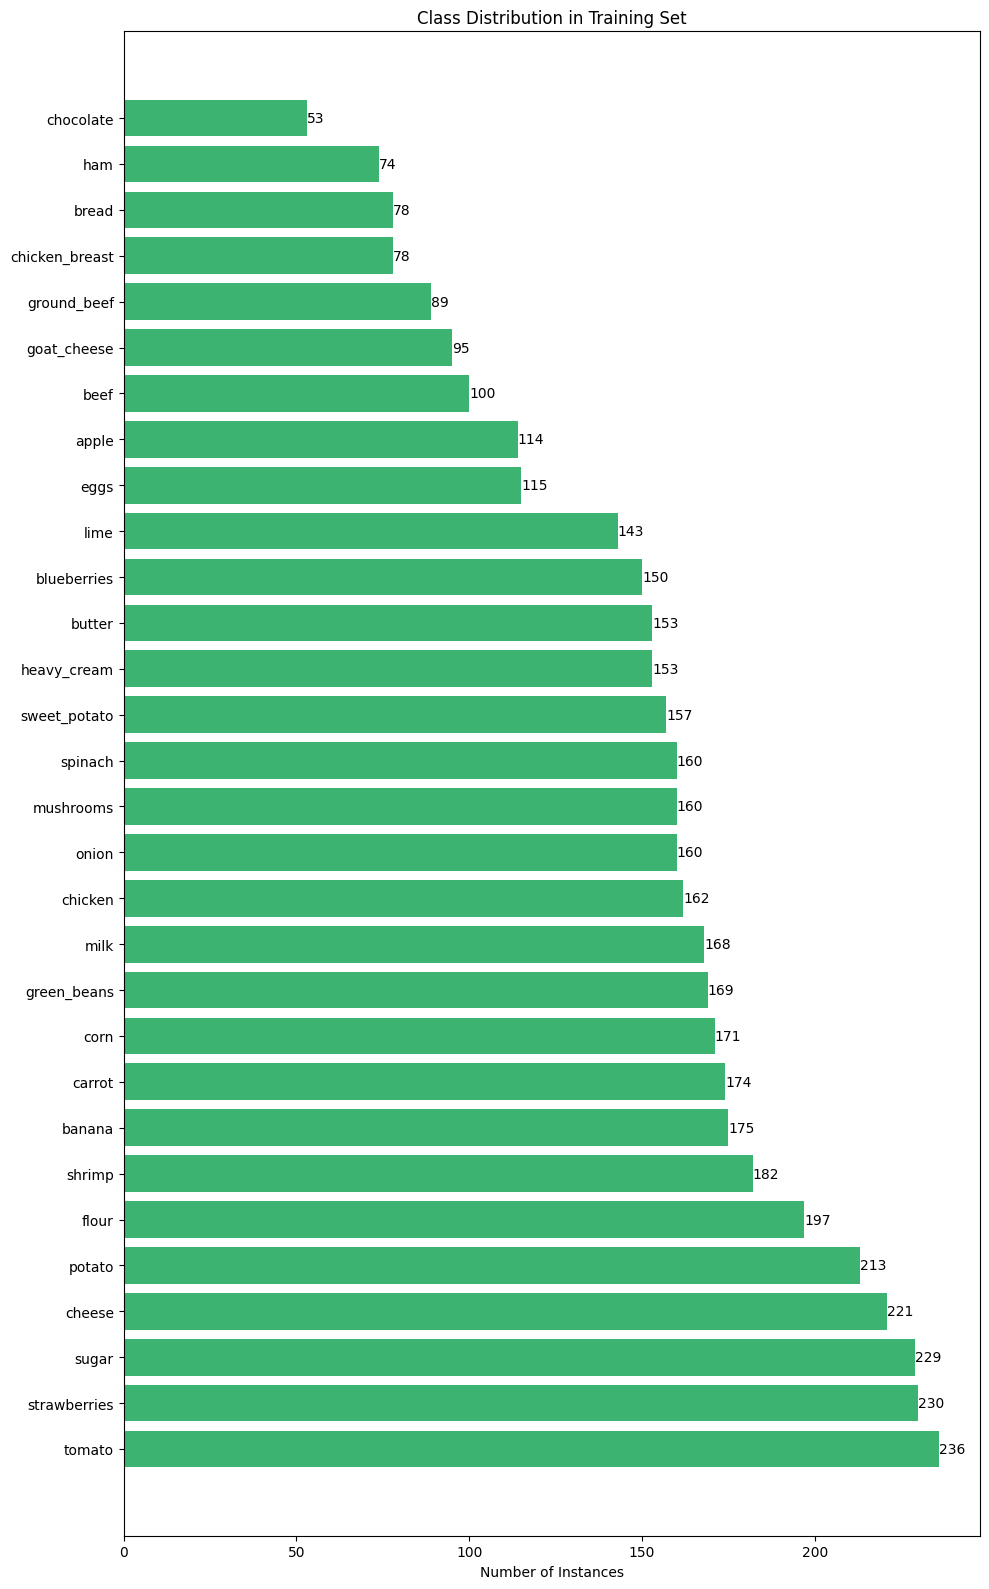

In [ ]:
import os
import matplotlib.pyplot as plt

labels_path = '/content/aicook-1/train/labels/'

# Class names (indexed from 0 to 29)
class_names = [
    'apple', 'banana', 'beef', 'blueberries', 'bread', 'butter',
    'carrot', 'cheese', 'chicken', 'chicken_breast', 'chocolate', 'corn',
    'eggs', 'flour', 'goat_cheese', 'green_beans', 'ground_beef', 'ham',
    'heavy_cream', 'lime', 'milk', 'mushrooms', 'onion', 'potato', 'shrimp',
    'spinach', 'strawberries', 'sugar', 'sweet_potato', 'tomato'
]

class_counts = {}


for file in os.listdir(labels_path):
    if file.endswith('.txt'):
        with open(os.path.join(labels_path, file), 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                class_counts[class_id] = class_counts.get(class_id, 0) + 1

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 16))

class_ids = sorted(class_counts.keys())
counts = [class_counts[cid] for cid in class_ids]
labels = [class_names[cid] for cid in class_ids]

sorted_items = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
class_ids, counts = zip(*sorted_items)
labels = [class_names[cid] for cid in class_ids]

bars = ax.barh(labels, counts, color='mediumseagreen')
ax.set_xlabel('Number of Instances')
ax.set_title('Class Distribution in Training Set')
ax.bar_label(bars)

plt.tight_layout()
plt.show()

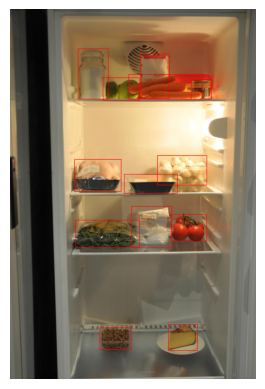

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_path = '/content/aicook-1/train/images/DSC_5680_JPG_jpg.rf.848821bf3a69ca77968602dbe5aadcb5.jpg'
label_path = '/content/aicook-1/train/labels/DSC_5680_JPG_jpg.rf.848821bf3a69ca77968602dbe5aadcb5.txt'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

with open(label_path, 'r') as f:
    for line in f:
        class_id, cx, cy, bw, bh = map(float, line.strip().split())
        x1 = int((cx - bw/2) * w)
        y1 = int((cy - bh/2) * h)
        x2 = int((cx + bw/2) * w)
        y2 = int((cy + bh/2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
import os
import cv2
import random
from collections import defaultdict

image_dir = "/content/aicook-1/train/images/"
label_dir = "/content/aicook-1/train/labels/"

class_counts = defaultdict(int)
labels_dict = defaultdict(list)

for label_file in os.listdir(label_dir):
    if not label_file.endswith(".txt"):
        continue
    with open(os.path.join(label_dir, label_file), "r") as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            class_id = parts[0]
            class_counts[class_id] += 1
            labels_dict[class_id].append((label_file, parts[1:]))

def calculate_needed_images(class_count, max_count):
    """ Calculates how many images should be added based on the class count relative to the max count. """
    if class_count >= max_count:
        return 0  # No augmentation needed for classes already at or above max_count
    else:
        # The number of images to add is based on the relative difference from the max count
        # For example, smaller classes will get larger increases
        difference = max_count - class_count
        scale_factor = 0.30
        return int(difference * scale_factor)

def yolo_to_pixel(bbox, img_width, img_height):
    x_center, y_center, width, height = bbox
    x1 = int((x_center - width / 2) * img_width)
    y1 = int((y_center - height / 2) * img_height)
    x2 = int((x_center + width / 2) * img_width)
    y2 = int((y_center + height / 2) * img_height)
    return x1, y1, x2, y2

# Now, for each class
max_class_count = max(class_counts.values())  # largest class size

for class_id, examples in labels_dict.items():
    current_count = class_counts[class_id]
    needed = calculate_needed_images(current_count, max_class_count)

    print(f"Class {class_id}: current {current_count}, need {needed} more images.")

    if needed <= 0:
        continue  # No need to augment this class since its already big enough

    idx = 0
    while needed > 0:
        # Randomly pick one existing bbox
        label_file, bbox = random.choice(examples)
        base_name = os.path.splitext(label_file)[0]
        img_path = os.path.join(image_dir, base_name + ".jpg")

        if not os.path.exists(img_path):
            continue

        image = cv2.imread(img_path)
        img_h, img_w = image.shape[:2]

        x1, y1, x2, y2 = yolo_to_pixel(list(map(float, bbox)), img_w, img_h)

        cropped = image[max(y1, 0):min(y2, img_h), max(x1, 0):min(x2, img_w)]

        if random.random() < 0.5:
            cropped = cv2.flip(cropped, 1)  # Horizontal flip for variety

        crop_name = f"{base_name}_aug{idx}_class{class_id}.jpg"
        cv2.imwrite(os.path.join(image_dir, crop_name), cropped)

        crop_label_name = f"{base_name}_aug{idx}_class{class_id}.txt"
        crop_label_path = os.path.join(label_dir, crop_label_name)

        # Since the object now fills the whole cropped image: x_center=0.5, y_center=0.5, width=1.0, height=1.0
        with open(crop_label_path, "w") as f:
            f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")

        needed -= 1
        idx += 1

Class 22: current 160, need 22 more images.
Class 14: current 95, need 42 more images.
Class 11: current 171, need 19 more images.
Class 29: current 236, need 0 more images.
Class 2: current 100, need 40 more images.
Class 27: current 229, need 2 more images.
Class 0: current 114, need 36 more images.
Class 24: current 182, need 16 more images.
Class 26: current 230, need 1 more images.
Class 1: current 175, need 18 more images.
Class 23: current 213, need 6 more images.
Class 7: current 221, need 4 more images.
Class 12: current 115, need 36 more images.
Class 10: current 53, need 54 more images.
Class 18: current 153, need 24 more images.
Class 9: current 78, need 47 more images.
Class 20: current 168, need 20 more images.
Class 21: current 160, need 22 more images.
Class 25: current 160, need 22 more images.
Class 19: current 143, need 27 more images.
Class 15: current 169, need 20 more images.
Class 8: current 162, need 22 more images.
Class 3: current 150, need 25 more images.
Cla

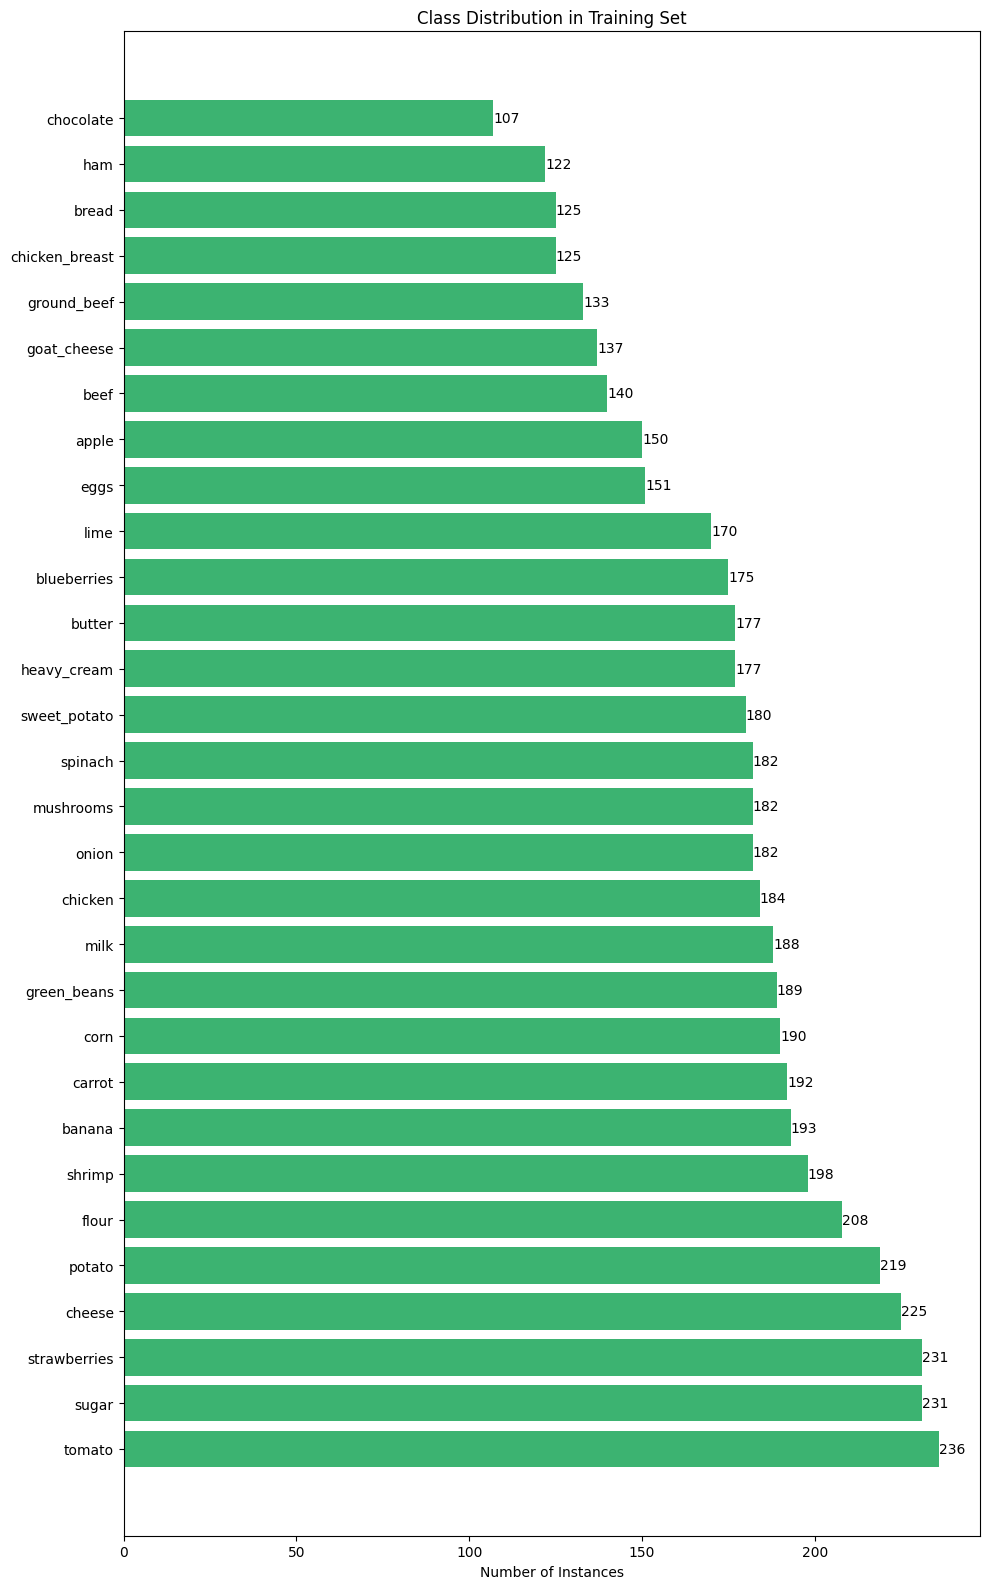

In [ ]:
import os
import matplotlib.pyplot as plt

labels_path = '/content/aicook-1/train/labels/'

# Class names (indexed from 0 to 29)
class_names = [
    'apple', 'banana', 'beef', 'blueberries', 'bread', 'butter',
    'carrot', 'cheese', 'chicken', 'chicken_breast', 'chocolate', 'corn',
    'eggs', 'flour', 'goat_cheese', 'green_beans', 'ground_beef', 'ham',
    'heavy_cream', 'lime', 'milk', 'mushrooms', 'onion', 'potato', 'shrimp',
    'spinach', 'strawberries', 'sugar', 'sweet_potato', 'tomato'
]

class_counts = {}

for file in os.listdir(labels_path):
    if file.endswith('.txt'):
        with open(os.path.join(labels_path, file), 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                class_counts[class_id] = class_counts.get(class_id, 0) + 1

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 16))

class_ids = sorted(class_counts.keys())
counts = [class_counts[cid] for cid in class_ids]
labels = [class_names[cid] for cid in class_ids]

sorted_items = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
class_ids, counts = zip(*sorted_items)
labels = [class_names[cid] for cid in class_ids]

bars = ax.barh(labels, counts, color='mediumseagreen')
ax.set_xlabel('Number of Instances')
ax.set_title('Class Distribution in Training Set')
ax.bar_label(bars)

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import albumentations as A
from albumentations.augmentations import transforms
from albumentations.pytorch import ToTensorV2
from albumentations.augmentations.dropout import CoarseDropout
from tqdm import tqdm

augment = A.Compose([
    A.HorizontalFlip(p=0.5),  # Randomly flip horizontally with 50% chance
    A.Rotate(limit=10, p=0.9),  # Random rotation between -10° and +10°, with 90% chance
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.8),
    A.GaussianBlur(blur_limit=(1, 3), p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),  # Slightly control noise amount
    A.CoarseDropout(num_holes_range=(1, 6),
                    hole_height_range=(0.05, 0.15),
                    hole_width_range=(0.05, 0.15),
                    fill_value=0,
                    p=1.0)  # Adds random black squares to help generalize model for overlapping objects
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
Argument(s) 'var_limit' are not valid for transform GaussNoise
Argument(s) 'fill_value' are not valid for transform CoarseDropout


In [ ]:
image_dir = "/content/aicook-1/train/images"
label_dir = "/content/aicook-1/train/labels"


In [ ]:
for img_name in tqdm(os.listdir(image_dir)):
    if not img_name.endswith(".jpg") and not img_name.endswith(".png"):
        continue

    base_name = os.path.splitext(img_name)[0]
    img_path = os.path.join(image_dir, img_name)
    lbl_path = os.path.join(label_dir, base_name + ".txt")

    # Load image and labels
    image = cv2.imread(img_path)
    h, w = image.shape[:2]

    with open(lbl_path, "r") as f:
        lines = f.readlines()
        labels = []
        bboxes = []
        for line in lines:
            parts = line.strip().split()
            labels.append(int(parts[0]))
            bboxes.append([float(x) for x in parts[1:]])


    # Augment 2 times
    for i in range(2):
        augmented = augment(image=image, bboxes=bboxes, class_labels=labels)
        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_labels = augmented['class_labels']

        out_img_name = f"{base_name}_aug{i}.jpg"
        out_lbl_name = f"{base_name}_aug{i}.txt"

        # Save image
        cv2.imwrite(os.path.join(image_dir, out_img_name), aug_image)

        # Save label
        with open(os.path.join(label_dir, out_lbl_name), "w") as f:
            for box, label in zip(aug_bboxes, aug_labels):
                f.write(f"{label} {' '.join(map(str, box))}\n")

100%|██████████| 1102/1102 [02:17<00:00,  8.02it/s]


In [ ]:
path = "/content/aicook-1/train/images"
print(len(os.listdir(path)))

3306


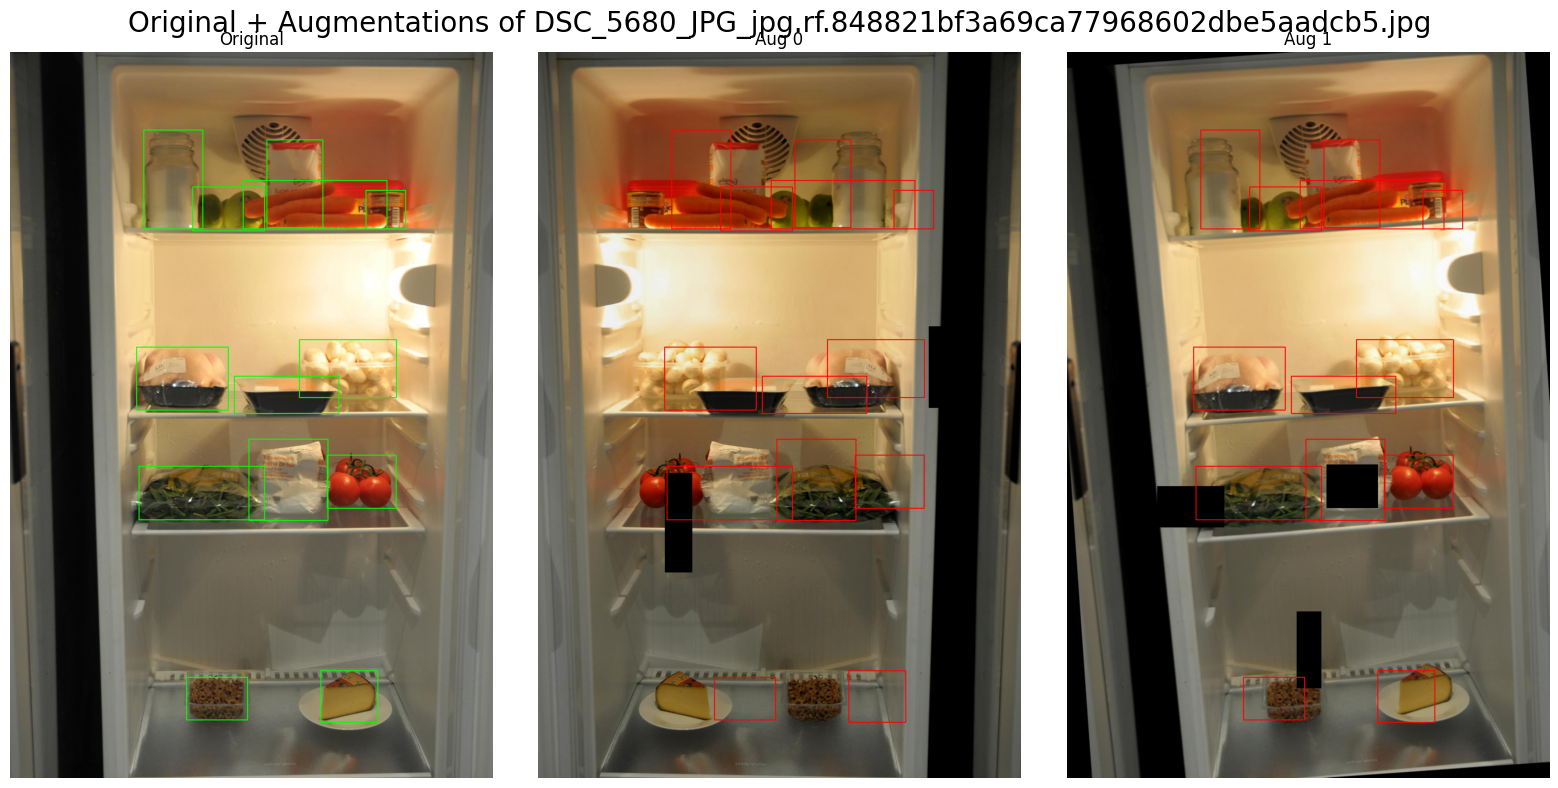

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

img_name = 'DSC_5680_JPG_jpg.rf.848821bf3a69ca77968602dbe5aadcb5.jpg'
label_name = 'DSC_5680_JPG_jpg.rf.848821bf3a69ca77968602dbe5aadcb5.txt'
base_name = os.path.splitext(img_name)[0]
output_img_dir = '/content/aicook-1/train/images'
label_path = os.path.join('/content/aicook-1/train/labels', label_name)

# --- load original image and label ---
original_img = cv2.imread(os.path.join('/content/aicook-1/train/images', img_name))
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
h, w, _ = original_img.shape

# --- load the labels ---
labels = []
with open(label_path, 'r') as f:
    for line in f:
        class_id, cx, cy, bw, bh = map(float, line.strip().split())
        x1 = int((cx - bw/2) * w)
        y1 = int((cy - bh/2) * h)
        x2 = int((cx + bw/2) * w)
        y2 = int((cy + bh/2) * h)
        labels.append((x1, y1, x2, y2))

# --- draw bounding boxes on original image ---
original_with_boxes = original_img.copy()
for (x1, y1, x2, y2) in labels:
    cv2.rectangle(original_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green for original

# --- load augmented images ---
aug_images = []
num_augs = 2
for i in range(num_augs):
    aug_path = os.path.join(output_img_dir, f"{base_name}_aug{i}.jpg")
    aug_img = cv2.imread(aug_path)
    aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)

    for (x1, y1, x2, y2) in labels:
        cv2.rectangle(aug_img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Red for augmentations

    aug_images.append(aug_img)

# --- plot ---
total_images = 1 + num_augs
cols = 3
rows = (total_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 8))
axes = axes.flatten()

# Plot original
axes[0].imshow(original_with_boxes)
axes[0].axis('off')
axes[0].set_title('Original')

# Plot augmentations
for idx, (ax, img) in enumerate(zip(axes[1:], aug_images)):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Aug {idx}')

# Hide any unused subplots
for ax in axes[1 + num_augs:]:
    ax.axis('off')

plt.suptitle(f'Original + Augmentations of {img_name}', fontsize=20)
plt.tight_layout()
plt.show()



In [ ]:
from ultralytics import YOLO

scratch_model = YOLO('yolov8n.yaml')
scratch_model.train(
    data='/content/aicook-1/data.yaml',
    epochs=100,
    imgsz=640,
    project='runs/train',
    name='fridge_scratch',
    pretrained=False,
    augment=False,
    patience=5
)

Ultralytics 8.3.120 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/aicook-1/data.yaml, epochs=100, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/train, name=fridge_scratch, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

100%|██████████| 755k/755k [00:00<00:00, 24.5MB/s]

Overriding model.yaml nc=80 with nc=30

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

YOLOv8n summary: 129 layers, 3,016,698 parameters, 3,016,682 gradients, 8.2 GFLOPs

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 108MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 988.1±663.6 MB/s, size: 37.1 KB)


train: Scanning /content/aicook-1/train/labels... 3306 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3306/3306 [00:01<00:00, 2317.75it/s]

train: New cache created: /content/aicook-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1172.2±927.8 MB/s, size: 171.7 KB)


val: Scanning /content/aicook-1/valid/labels... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<00:00, 1313.56it/s]

val: New cache created: /content/aicook-1/valid/labels.cache


Plotting labels to runs/train/fridge_scratch/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000294, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/train/fridge_scratch
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.39G      3.855      5.136      4.149         80        640: 100%|██████████| 207/207 [01:19<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        103       1227    0.00807     0.0227     0.0078    0.00218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.52G      3.157      4.532      3.439         57        640: 100%|██████████| 207/207 [01:16<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


                   all        103       1227      0.397      0.145     0.0543     0.0224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.54G      2.568      3.739       2.71        119        640: 100%|██████████| 207/207 [01:15<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]


                   all        103       1227      0.507      0.164      0.194     0.0871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.68G      2.078      3.111      2.212         89        640: 100%|██████████| 207/207 [01:15<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


                   all        103       1227      0.465       0.37       0.37      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.7G      1.777      2.668      1.908         76        640: 100%|██████████| 207/207 [01:16<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


                   all        103       1227       0.44      0.493      0.492      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.71G      1.603      2.354      1.725         97        640: 100%|██████████| 207/207 [01:15<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


                   all        103       1227      0.562       0.58        0.6      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.73G      1.507      2.158      1.626         80        640: 100%|██████████| 207/207 [01:16<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


                   all        103       1227      0.604      0.656      0.674      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.75G      1.414      2.012      1.548         63        640: 100%|██████████| 207/207 [01:14<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        103       1227      0.629      0.685      0.718      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.77G      1.355      1.908      1.506        140        640: 100%|██████████| 207/207 [01:15<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.80it/s]

                   all        103       1227       0.68      0.685      0.745      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.78G      1.314      1.804      1.476        117        640: 100%|██████████| 207/207 [01:16<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all        103       1227      0.737      0.723      0.783      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.93G      1.275      1.706      1.441        111        640: 100%|██████████| 207/207 [01:16<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


                   all        103       1227      0.776      0.737      0.809      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.95G      1.235      1.633      1.414         85        640: 100%|██████████| 207/207 [01:15<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        103       1227      0.786      0.739      0.826      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.96G      1.186      1.569      1.381         65        640: 100%|██████████| 207/207 [01:14<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]


                   all        103       1227      0.805      0.769      0.848       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.97G      1.178      1.513      1.371         76        640: 100%|██████████| 207/207 [01:15<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


                   all        103       1227      0.815      0.793      0.868      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         3G      1.154      1.446      1.349         71        640: 100%|██████████| 207/207 [01:15<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.91it/s]


                   all        103       1227      0.811      0.783      0.855      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.01G      1.129      1.403      1.333         60        640: 100%|██████████| 207/207 [01:15<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


                   all        103       1227      0.838      0.809      0.876      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.03G      1.109      1.353      1.315         86        640: 100%|██████████| 207/207 [01:14<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


                   all        103       1227      0.832      0.819      0.889      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.04G      1.099      1.322      1.304         98        640: 100%|██████████| 207/207 [01:14<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        103       1227      0.835      0.819      0.882      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.07G      1.088      1.303      1.297         53        640: 100%|██████████| 207/207 [01:15<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


                   all        103       1227      0.822      0.817      0.872      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.21G      1.092      1.264      1.297         93        640: 100%|██████████| 207/207 [01:15<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


                   all        103       1227      0.867      0.824      0.895      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.23G      1.063      1.222      1.272         78        640: 100%|██████████| 207/207 [01:15<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


                   all        103       1227      0.842      0.843      0.909      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.24G      1.056      1.208      1.271         68        640: 100%|██████████| 207/207 [01:16<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


                   all        103       1227      0.864      0.828      0.903      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.27G      1.051      1.187      1.261         77        640: 100%|██████████| 207/207 [01:15<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.87it/s]

                   all        103       1227      0.835      0.868      0.908      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.28G      1.026      1.159      1.255         64        640: 100%|██████████| 207/207 [01:16<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


                   all        103       1227      0.842      0.857      0.907      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       3.3G      1.037      1.136      1.255         64        640: 100%|██████████| 207/207 [01:16<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


                   all        103       1227       0.87      0.853      0.907      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.31G     0.9989       1.11      1.242        103        640: 100%|██████████| 207/207 [01:15<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        103       1227      0.879      0.866      0.917      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.33G      1.001       1.09      1.234        162        640: 100%|██████████| 207/207 [01:15<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


                   all        103       1227      0.886      0.883      0.916      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.35G     0.9871      1.064       1.23        102        640: 100%|██████████| 207/207 [01:14<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


                   all        103       1227      0.902      0.863      0.923      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.37G     0.9856      1.054      1.225         72        640: 100%|██████████| 207/207 [01:15<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        103       1227      0.901      0.864      0.924      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.38G     0.9774      1.041      1.222         74        640: 100%|██████████| 207/207 [01:14<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


                   all        103       1227      0.872      0.884      0.918      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       3.4G     0.9667      1.016      1.208         78        640: 100%|██████████| 207/207 [01:14<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


                   all        103       1227      0.893      0.882      0.924      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.42G      0.964      1.013      1.209        123        640: 100%|██████████| 207/207 [01:15<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


                   all        103       1227      0.878      0.899      0.933      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.44G     0.9554      1.001      1.205         99        640: 100%|██████████| 207/207 [01:15<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.84it/s]

                   all        103       1227      0.875      0.895      0.924      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.44G     0.9481     0.9828      1.206         83        640: 100%|██████████| 207/207 [01:14<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


                   all        103       1227      0.904       0.89      0.931      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.47G     0.9342     0.9681      1.199         88        640: 100%|██████████| 207/207 [01:14<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


                   all        103       1227      0.903      0.906       0.94      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.49G     0.9411     0.9594      1.195         60        640: 100%|██████████| 207/207 [01:14<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]


                   all        103       1227      0.911      0.899      0.943      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       3.5G     0.9228     0.9438       1.19        116        640: 100%|██████████| 207/207 [01:12<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]

                   all        103       1227      0.885      0.903      0.934      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.51G     0.9318     0.9305      1.187         74        640: 100%|██████████| 207/207 [01:13<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]

                   all        103       1227      0.904      0.906      0.933      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.54G     0.9263     0.9213      1.182         67        640: 100%|██████████| 207/207 [01:12<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        103       1227      0.923      0.897       0.94      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.56G     0.9179     0.9045      1.177         39        640: 100%|██████████| 207/207 [01:14<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        103       1227      0.915      0.897      0.941      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.57G     0.9109     0.9015      1.178         71        640: 100%|██████████| 207/207 [01:14<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        103       1227      0.921      0.912      0.948      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.58G     0.9083     0.8884      1.172        119        640: 100%|██████████| 207/207 [01:13<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        103       1227      0.901      0.911      0.941      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.61G     0.9061     0.8832      1.171         67        640: 100%|██████████| 207/207 [01:13<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


                   all        103       1227      0.913      0.903      0.943      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.62G      0.905     0.8721      1.172         90        640: 100%|██████████| 207/207 [01:12<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]

                   all        103       1227       0.92      0.888      0.942      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.64G     0.8953     0.8607      1.165         61        640: 100%|██████████| 207/207 [01:12<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


                   all        103       1227      0.928      0.907      0.944      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.65G      0.901      0.854      1.168         47        640: 100%|██████████| 207/207 [01:14<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        103       1227      0.913      0.907      0.935      0.598


EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 41, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

46 epochs completed in 0.991 hours.
Optimizer stripped from runs/train/fridge_scratch/weights/last.pt, 6.2MB
Optimizer stripped from runs/train/fridge_scratch/weights/best.pt, 6.2MB

Validating runs/train/fridge_scratch/weights/best.pt...
Ultralytics 8.3.120 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,011,498 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]


                   all        103       1227      0.921      0.912      0.948      0.607
                 apple         43         44      0.928       0.88      0.942      0.658
                banana         41         41      0.934      0.976      0.992      0.729
                  beef         24         24      0.914      0.886      0.891      0.375
           blueberries         33         33          1      0.806      0.952      0.557
                 bread         41         41      0.943      0.806      0.907      0.602
                butter         32         32      0.959      0.969      0.993      0.769
                carrot         35         37      0.793      0.838      0.907      0.564
                cheese         49         49      0.945      0.878      0.977      0.639
               chicken         27         27      0.988          1      0.995      0.703
        chicken_breast         35         35      0.772      0.943      0.884      0.359
             chocolat

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7add6cdefa10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.0

In [ ]:
from ultralytics import YOLO

# Load base model
pretrained_model = YOLO('yolov8n.pt')

# Train the model
pretrained_model.train(
    data='/content/aicook-1/data.yaml',
    epochs=100,
    imgsz=640,
    project='runs/train',
    name='fridge_pretrained',
    augment=False,
    patience=5
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 136MB/s]

Ultralytics 8.3.120 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/aicook-1/data.yaml, epochs=100, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=runs/train, name=fridge_pretrained, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192, 64, 1]                  
 16                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    123648  ultralytics.nn.modules.block.C2f             [192, 128, 1]                 
 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

train: Scanning /content/aicook-1/train/labels.cache... 3306 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3306/3306 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1434.0±856.5 MB/s, size: 171.7 KB)


val: Scanning /content/aicook-1/valid/labels.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]


Plotting labels to runs/train/fridge_pretrained/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000294, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/train/fridge_pretrained
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.87G      1.046      3.764      1.124         80        640: 100%|██████████| 207/207 [01:17<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


                   all        103       1227       0.42      0.526      0.466      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.97G     0.9772      2.152      1.077         57        640: 100%|██████████| 207/207 [01:14<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


                   all        103       1227      0.715      0.815      0.815      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.97G     0.9094      1.582      1.048        119        640: 100%|██████████| 207/207 [01:13<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


                   all        103       1227      0.847      0.826      0.905      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       3.1G      0.875      1.369      1.032         89        640: 100%|██████████| 207/207 [01:13<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]


                   all        103       1227      0.874      0.863      0.913      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       3.1G     0.8399      1.239      1.017         76        640: 100%|██████████| 207/207 [01:14<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        103       1227      0.863      0.912      0.939      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       3.1G     0.8318      1.144      1.009         97        640: 100%|██████████| 207/207 [01:14<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


                   all        103       1227      0.929      0.913      0.942      0.612

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       3.1G     0.8111      1.059          1         80        640: 100%|██████████| 207/207 [01:16<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.12it/s]


                   all        103       1227      0.912       0.94      0.952      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       3.1G     0.7899      1.011     0.9926         63        640: 100%|██████████| 207/207 [01:15<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


                   all        103       1227      0.915      0.937      0.958      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       3.1G     0.7762     0.9709     0.9916        140        640: 100%|██████████| 207/207 [01:15<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


                   all        103       1227      0.935      0.907      0.952      0.628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       3.1G     0.7767     0.9335       0.99        117        640: 100%|██████████| 207/207 [01:16<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


                   all        103       1227      0.936      0.942      0.966      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.23G     0.7641     0.8852     0.9847        111        640: 100%|██████████| 207/207 [01:16<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


                   all        103       1227      0.936      0.942      0.965      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.23G     0.7581     0.8659     0.9824         85        640: 100%|██████████| 207/207 [01:15<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        103       1227      0.928      0.954       0.96      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.23G     0.7389     0.8454     0.9791         65        640: 100%|██████████| 207/207 [01:16<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


                   all        103       1227      0.939      0.948      0.957      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.23G     0.7413     0.8186      0.978         76        640: 100%|██████████| 207/207 [01:16<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]


                   all        103       1227      0.938      0.958      0.965      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.23G     0.7357     0.7798     0.9734         71        640: 100%|██████████| 207/207 [01:16<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


                   all        103       1227      0.942      0.955      0.963      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.23G     0.7225     0.7679     0.9721         60        640: 100%|██████████| 207/207 [01:15<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


                   all        103       1227      0.947      0.947      0.961      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.23G     0.7197     0.7385      0.968         86        640: 100%|██████████| 207/207 [01:15<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]


                   all        103       1227       0.95      0.954      0.968      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.23G     0.7148     0.7301     0.9632         98        640: 100%|██████████| 207/207 [01:15<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


                   all        103       1227      0.948      0.948      0.966      0.646

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.23G     0.7123     0.7202     0.9628         53        640: 100%|██████████| 207/207 [01:16<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


                   all        103       1227      0.932      0.958       0.96      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.36G     0.7212     0.7061     0.9652         93        640: 100%|██████████| 207/207 [01:15<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.00it/s]


                   all        103       1227      0.928      0.961      0.961      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.36G     0.7057      0.688     0.9596         78        640: 100%|██████████| 207/207 [01:15<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


                   all        103       1227      0.934      0.957      0.959      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.36G      0.698     0.6733     0.9589         68        640: 100%|██████████| 207/207 [01:13<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        103       1227       0.94      0.957      0.969      0.643
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 17, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



22 epochs completed in 0.477 hours.
Optimizer stripped from runs/train/fridge_pretrained/weights/last.pt, 6.2MB
Optimizer stripped from runs/train/fridge_pretrained/weights/best.pt, 6.2MB

Validating runs/train/fridge_pretrained/weights/best.pt...
Ultralytics 8.3.120 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,011,498 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


                   all        103       1227       0.95      0.955      0.968      0.646
                 apple         43         44      0.977      0.947      0.972      0.788
                banana         41         41          1      0.995      0.995      0.751
                  beef         24         24          1       0.73      0.938      0.326
           blueberries         33         33      0.988       0.97      0.968       0.68
                 bread         41         41      0.975      0.948      0.971      0.697
                butter         32         32      0.967          1      0.995      0.739
                carrot         35         37      0.896      0.931       0.95      0.556
                cheese         49         49      0.959          1      0.995      0.744
               chicken         27         27      0.988          1      0.995      0.652
        chicken_breast         35         35       0.65        0.8      0.734      0.251
             chocolat

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7add6c5506d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.0

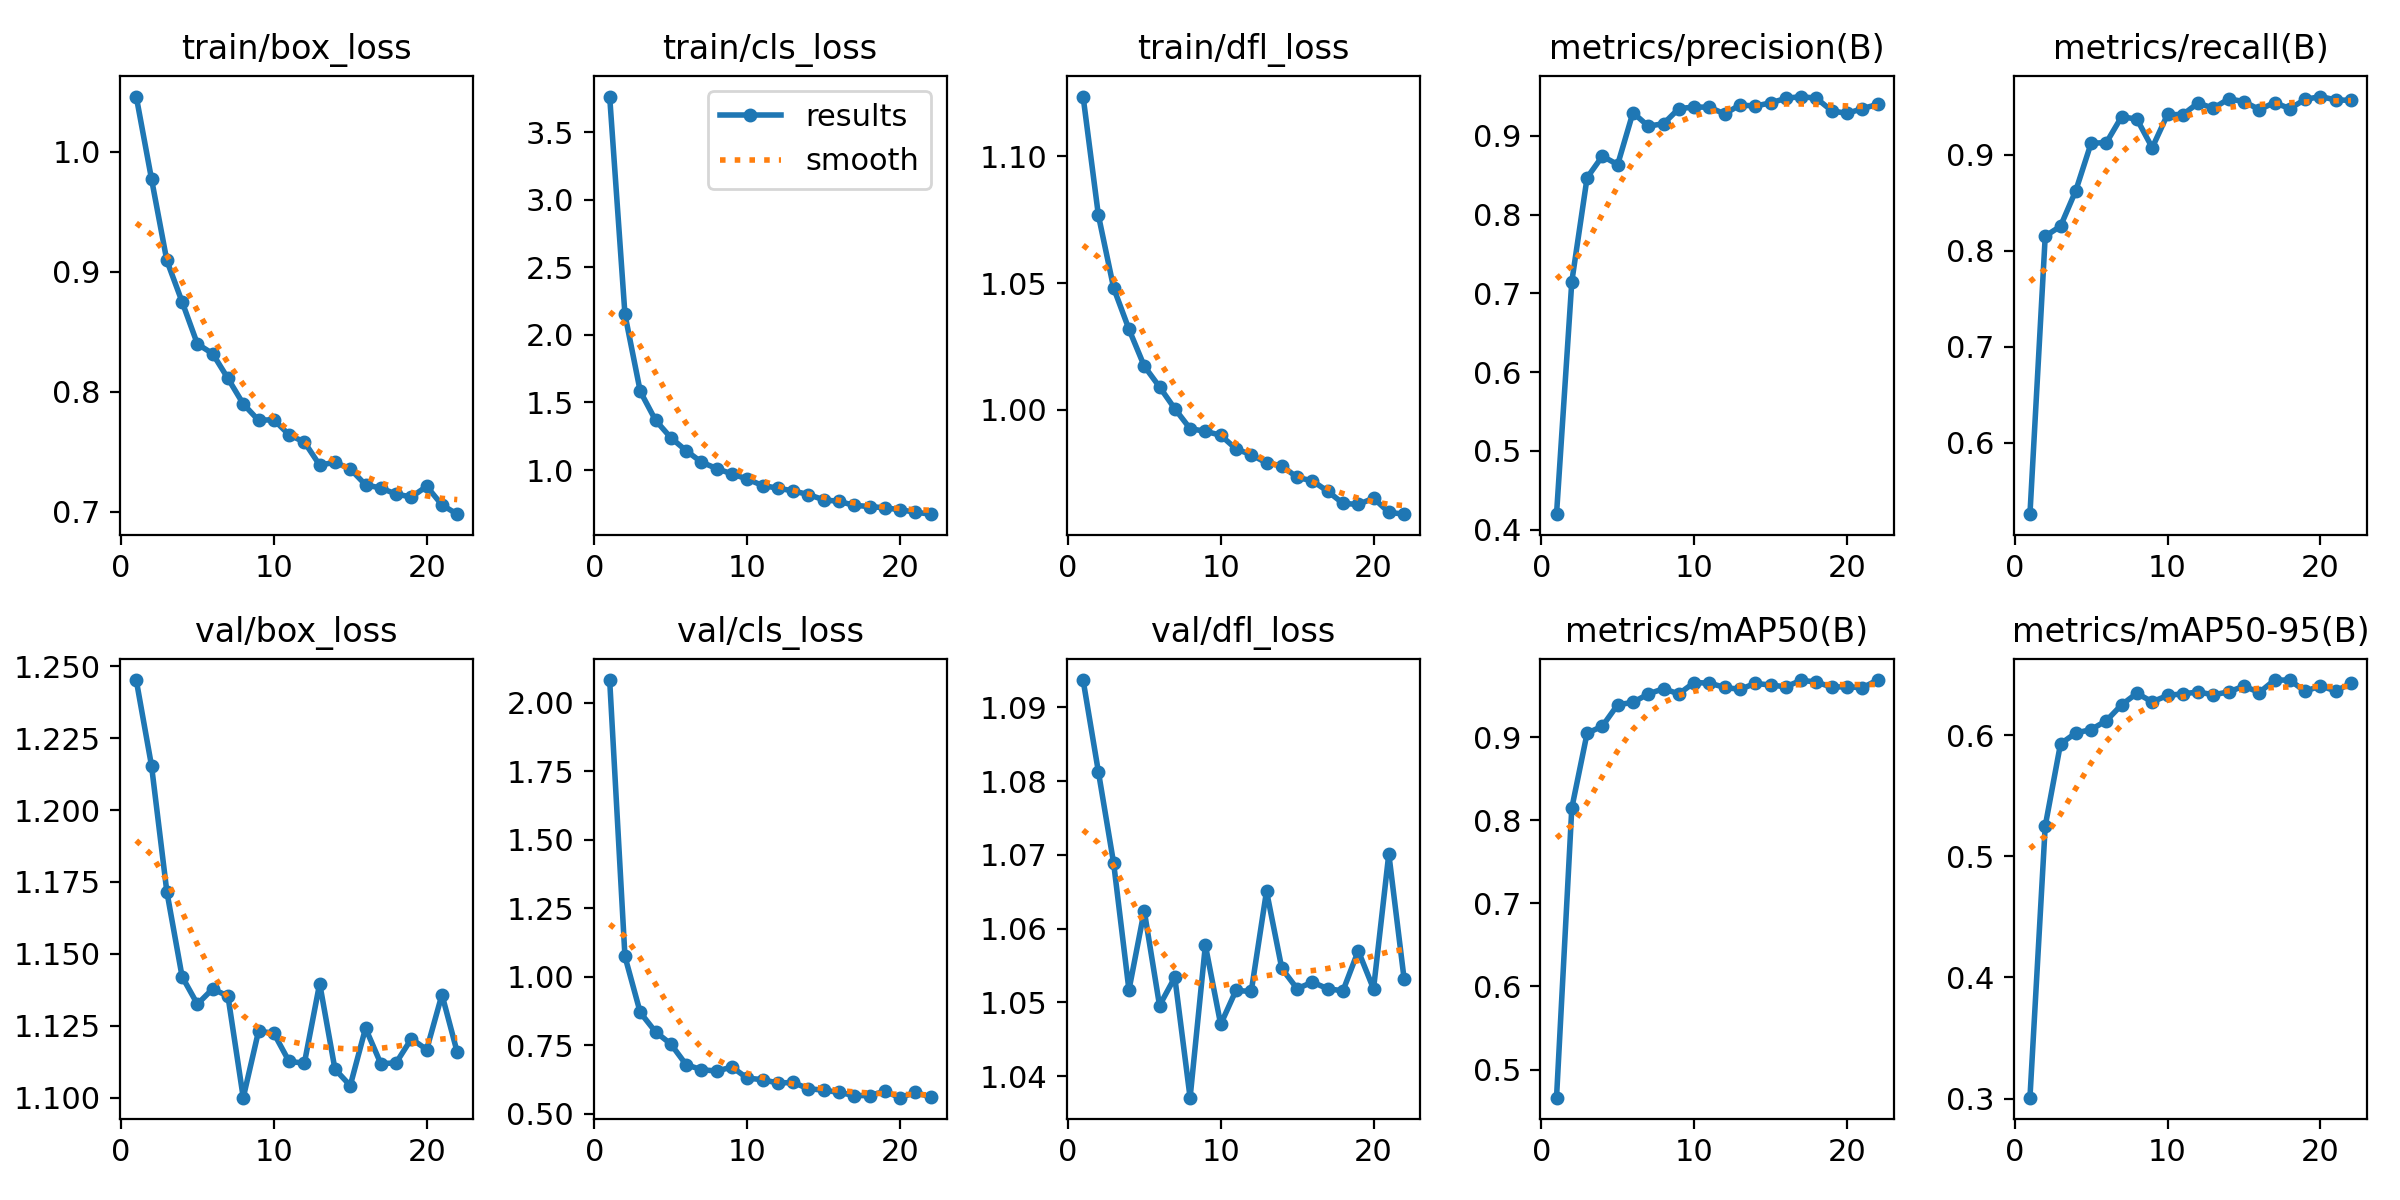

In [ ]:
from IPython.display import Image

# Pretrained
Image(filename='runs/train/fridge_pretrained/results.png', width=800)

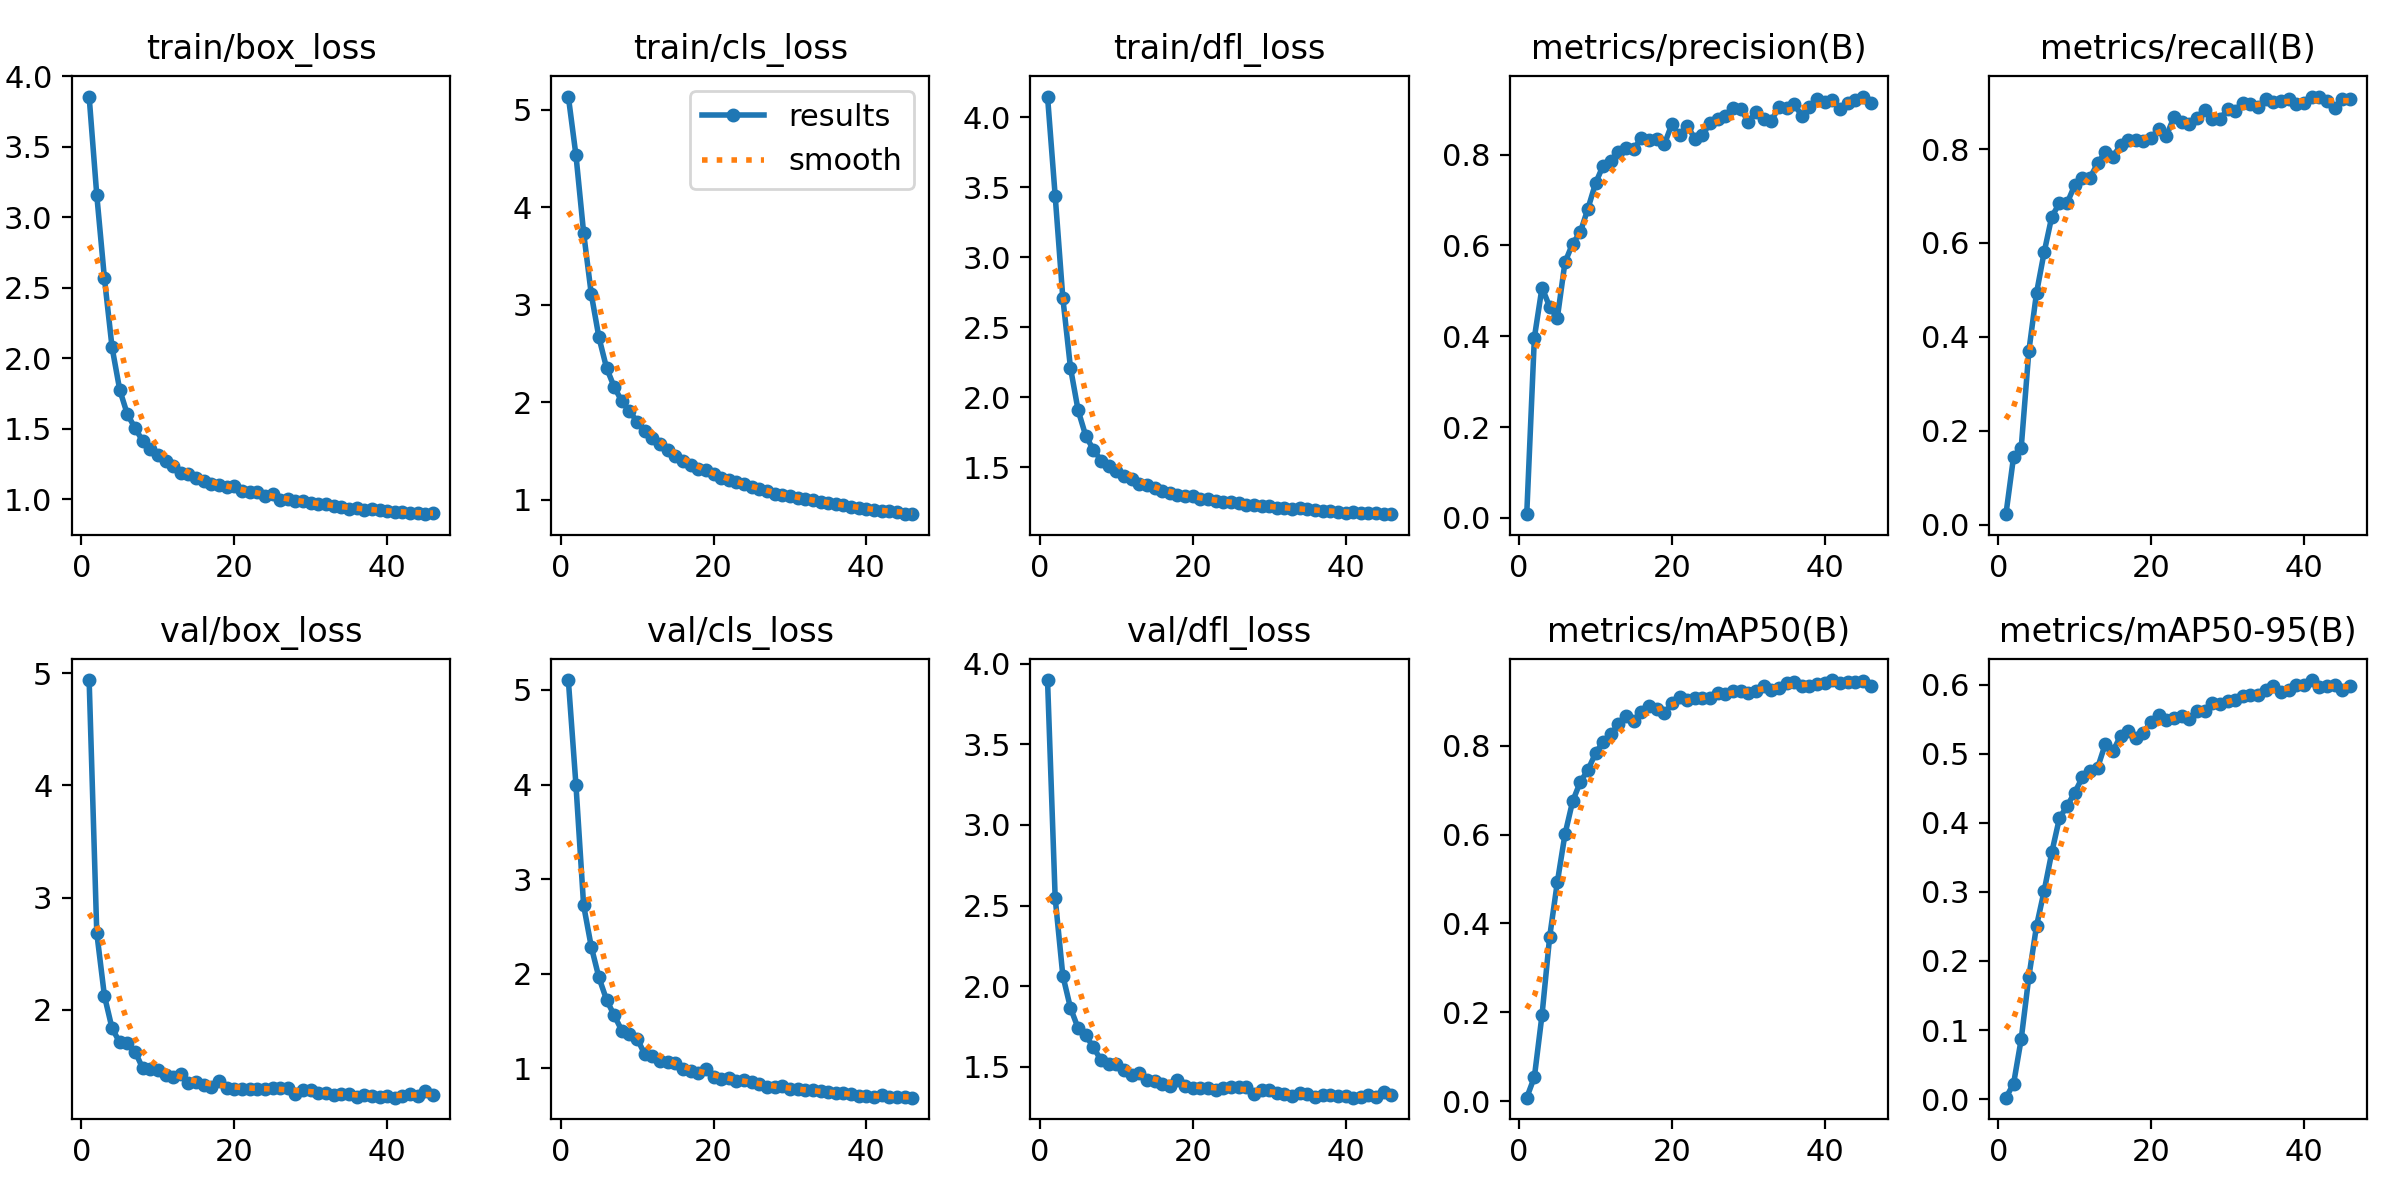

In [ ]:
# From Scratch
Image(filename='runs/train/fridge_scratch/results.png', width=800)

In [ ]:
# Validation
pretrained_metrics = pretrained_model.val()
scratch_metrics = scratch_model.val()

# Inference on a test image
pretrained_results = pretrained_model.predict('/content/aicook-1/test/images/DSC_5941_JPG_jpg.rf.c00e39d13c6fd142558dc2cc8424a0f5.jpg', save=True, conf=0.25)
scratch_results = scratch_model.predict('/content/aicook-1/test/images/DSC_5941_JPG_jpg.rf.c00e39d13c6fd142558dc2cc8424a0f5.jpg', save=True, conf=0.25)

Ultralytics 8.3.120 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,011,498 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2247.2±931.4 MB/s, size: 180.8 KB)


val: Scanning /content/aicook-1/valid/labels.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.18it/s]


                   all        103       1227       0.95      0.955      0.967      0.645
                 apple         43         44      0.977      0.947      0.972      0.779
                banana         41         41          1      0.995      0.995      0.752
                  beef         24         24          1      0.729      0.938      0.329
           blueberries         33         33      0.988       0.97      0.968      0.678
                 bread         41         41      0.975      0.948      0.971      0.699
                butter         32         32      0.967          1      0.995      0.738
                carrot         35         37      0.896      0.931       0.95      0.558
                cheese         49         49       0.96          1      0.995      0.743
               chicken         27         27      0.988          1      0.995      0.652
        chicken_breast         35         35      0.651      0.798      0.735      0.255
             chocolat

val: Scanning /content/aicook-1/valid/labels.cache... 103 images, 0 backgrounds, 0 corrupt: 100%|██████████| 103/103 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]


                   all        103       1227      0.921      0.911      0.948      0.607
                 apple         43         44      0.928       0.88      0.942      0.665
                banana         41         41      0.933      0.976      0.992      0.721
                  beef         24         24      0.914      0.886      0.891      0.375
           blueberries         33         33          1      0.804      0.952      0.546
                 bread         41         41      0.943      0.806      0.907      0.602
                butter         32         32      0.959      0.969      0.993      0.762
                carrot         35         37      0.793      0.838      0.907      0.565
                cheese         49         49      0.945      0.878      0.977      0.642
               chicken         27         27      0.988          1      0.995      0.703
        chicken_breast         35         35      0.772      0.943      0.884      0.357
             chocolat

In [ ]:
import sys
import numpy as np
import pandas as pd
import sklearn
import torch

# System Info
print("Python version:", sys.version)
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("PyTorch version:", torch.__version__)

# GPU Info
if torch.cuda.is_available():
    print("CUDA Available:", torch.cuda.is_available())
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA Version:", torch.version.cuda)
else:
    print("CUDA not available.")

Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
NumPy version: 2.0.2
Pandas version: 2.2.2
Scikit-learn version: 1.6.1
PyTorch version: 2.6.0+cu124
CUDA Available: True
GPU Name: Tesla T4
CUDA Version: 12.4


In [ ]:
# Compress the folder
!zip -r runs_folder.zip runs/

# Download the zip file
from google.colab import files
files.download("runs_folder.zip")

  adding: runs/ (stored 0%)
  adding: runs/train/ (stored 0%)
  adding: runs/train/fridge_pretrained3/ (stored 0%)
  adding: runs/train/fridge_pretrained3/DSC_5941_JPG_jpg.rf.c00e39d13c6fd142558dc2cc8424a0f5.jpg (deflated 6%)
  adding: runs/train/fridge_scratch/ (stored 0%)
  adding: runs/train/fridge_scratch/F1_curve.png (deflated 9%)
  adding: runs/train/fridge_scratch/results.csv (deflated 61%)
  adding: runs/train/fridge_scratch/train_batch0.jpg (deflated 4%)
  adding: runs/train/fridge_scratch/val_batch1_pred.jpg (deflated 5%)
  adding: runs/train/fridge_scratch/weights/ (stored 0%)
  adding: runs/train/fridge_scratch/weights/last.pt (deflated 10%)
  adding: runs/train/fridge_scratch/weights/best.pt (deflated 10%)
  adding: runs/train/fridge_scratch/confusion_matrix_normalized.png (deflated 20%)
  adding: runs/train/fridge_scratch/train_batch2.jpg (deflated 4%)
  adding: runs/train/fridge_scratch/PR_curve.png (deflated 15%)
  adding: runs/train/fridge_scratch/val_batch2_pred.jpg (

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

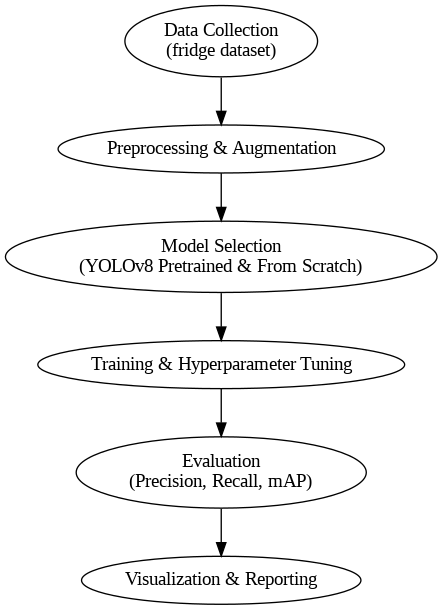

In [ ]:
!pip install graphviz
from graphviz import Digraph

dot = Digraph()

dot.node('A', 'Data Collection\n(fridge dataset)')
dot.node('B', 'Preprocessing & Augmentation')
dot.node('C', 'Model Selection\n(YOLOv8 Pretrained & From Scratch)')
dot.node('D', 'Training & Hyperparameter Tuning')
dot.node('E', 'Evaluation\n(Precision, Recall, mAP)')
dot.node('F', 'Visualization & Reporting')

dot.edges(['AB', 'BC', 'CD', 'DE', 'EF'])

dot.render('pipeline_diagram', format='png', cleanup=True)
from IPython.display import Image
Image(filename='pipeline_diagram.png')